# Final Lab

## Main task

In this notebook, we will apply transfer learning techniques to finetune the [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) CNN on [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

## Procedures

In general, the main steps that we will follow are:

1. Load data, analyze and split in *training*/*validation*/*testing* sets.
2. Load CNN and analyze architecture.
3. Adapt this CNN to our problem.
4. Setup data augmentation techniques.
5. Add some keras callbacks.
6. Setup optimization algorithm with their hyperparameters.
7. Train model!
8. Choose best model/snapshot.
9. Evaluate final model on the *testing* set.


In [1]:
# Setup one GPU for tensorflow (don't be greedy).
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0", "1", etc.
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

# https://keras.io/applications/#documentation-for-individual-models
import keras
from keras.applications.mobilenet import MobileNet
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from utils import *

# Limit tensorflow gpu usage.
# Maybe you should comment this lines if you run tensorflow on CPU.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
sess = tf.Session(config=config)

Using TensorFlow backend.


## 1. Load data, analyze and split in *training*/*validation*/*testing* sets

In [2]:
# Cifar-10 class names
# We will create a dictionary for each type of label
# This is a mapping from the int class name to 
# their corresponding string class name
LABELS = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
# Load dataset from keras
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
############
# [COMPLETE] 
# Add some prints here to see the loaded data dimensions
print("cifar10 X_train shape: {}".format(X_train.shape))
print("cifar10 y_train shape: {}".format(y_train.shape))
print("cifar10 X_test shape: {}".format(X_test.shape))
print("cifar10 y_test shape: {}".format(y_test.shape))
############

cifar10 X_train shape: (50000, 32, 32, 3)
cifar10 y_train shape: (50000, 1)
cifar10 X_test shape: (10000, 32, 32, 3)
cifar10 y_test shape: (10000, 1)


In [3]:
y_train = y_train.reshape((50000,))
y_test = y_test.reshape((10000,))

airplane       :  5000 or 10.00%
automobile     :  5000 or 10.00%
bird           :  5000 or 10.00%
cat            :  5000 or 10.00%
deer           :  5000 or 10.00%
dog            :  5000 or 10.00%
frog           :  5000 or 10.00%
horse          :  5000 or 10.00%
ship           :  5000 or 10.00%
truck          :  5000 or 10.00%


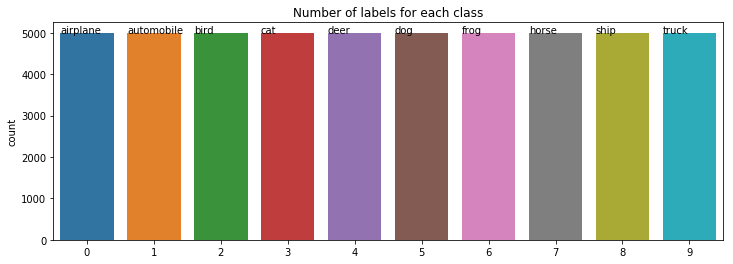

Total number of sample images to plot:  40


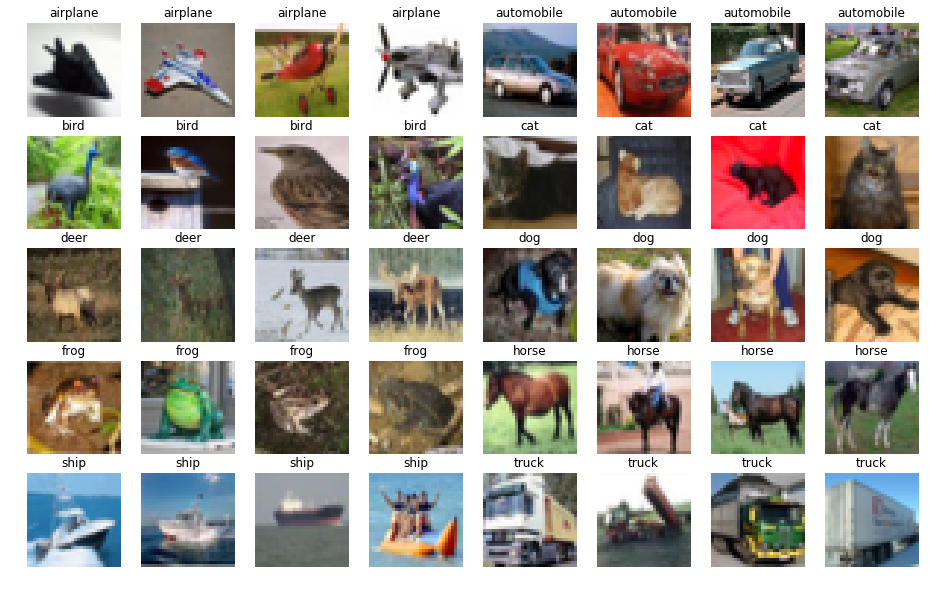

In [4]:
############
# [COMPLETE] 
# Analyze the amount of images for each class
# Plot some images to explore how they look
train_label_counts = get_classes_distribution(y_train, LABELS)
plot_label_per_class(y_train, LABELS)
train_sample_images, train_sample_labels = sample_images_data(X_train, y_train, LABELS)
plot_sample_images(train_sample_images, train_sample_labels, LABELS)
############

Veamos ahora los datos de test

airplane       :  1000 or 10.00%
automobile     :  1000 or 10.00%
bird           :  1000 or 10.00%
cat            :  1000 or 10.00%
deer           :  1000 or 10.00%
dog            :  1000 or 10.00%
frog           :  1000 or 10.00%
horse          :  1000 or 10.00%
ship           :  1000 or 10.00%
truck          :  1000 or 10.00%


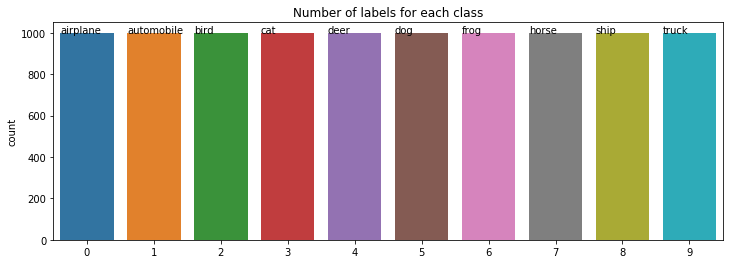

Total number of sample images to plot:  40


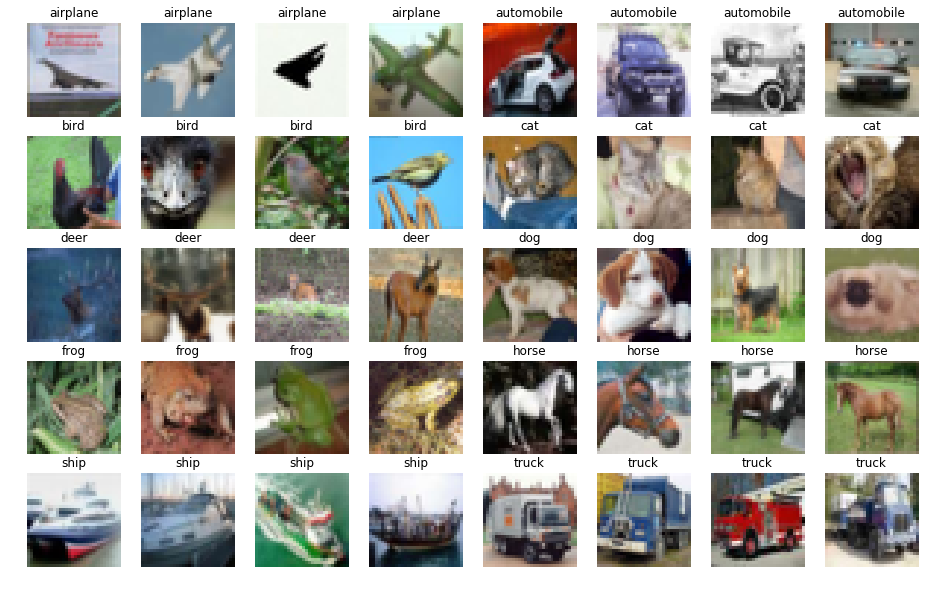

In [5]:
test_label_counts = get_classes_distribution(y_test, LABELS)
plot_label_per_class(y_test, LABELS)
test_sample_images, test_sample_labels = sample_images_data(X_test, y_test, LABELS)
plot_sample_images(test_sample_images, test_sample_labels, LABELS)

### Conclusiones hasta el momento:

Podemos concluir que el dataset se encuentra correctamente balanceado a nivel de clases y que tanto los datos de entrenamiento como de test poseen características similares. 

Esto último es un aspecto importante a tener en cuenta pues, para obtener buenos resultados a priori es ideal saber que los datos que se utilizan para entrenar el modelo son representativos a los datos contra los que se va a testear el mismo.

In [6]:
# Some constants
IMG_ROWS = 32
IMG_COLS = 32
CHANNELS = 3
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 77

In [7]:
############
# [COMPLETE] 
# Split training set in train/val sets
# Use the sampling method that you want
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print("CIFAR-10 X train  -  rows: {}  columns: {}".format(X_train.shape[0], X_train.shape[1:4]))
print("CIFAR-10 X valid  -  rows: {}  columns: {}".format(X_val.shape[0], X_val.shape[1:4]))
print("CIFAR-10 X test   -  rows: {}  columns: {}".format(X_test.shape[0], X_test.shape[1:4]))
print("-----------------------------------------------------------")
print("CIFAR-10 y train shape {}".format(y_train.shape))
print("CIFAR-10 y valid shape {}".format(y_val.shape))
print("CIFAR-10 y test shape {}".format(y_test.shape))
############

CIFAR-10 X train  -  rows: 40000  columns: (32, 32, 3)
CIFAR-10 X valid  -  rows: 10000  columns: (32, 32, 3)
CIFAR-10 X test   -  rows: 10000  columns: (32, 32, 3)
-----------------------------------------------------------
CIFAR-10 y train shape (40000,)
CIFAR-10 y valid shape (10000,)
CIFAR-10 y test shape (10000,)


In [8]:
def save_to_disk(x_data, y_data, usage, output_dir='cifar10_images'):
    """
    This function will resize your data using the specified output_size and 
    save them to output_dir. 
    x_data : np.ndarray
        Array with images.  
    y_data : np.ndarray
        Array with labels.    
    usage : str
        One of ['train', 'val', 'test'].
    output_dir : str
        Path to save data.
    """
    assert usage in ['train', 'val', 'test']
    # Set paths 
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for label in np.unique(y_data):
        label_path = os.path.join(output_dir, usage, str(label))
        if not os.path.exists(label_path):
            os.makedirs(label_path)
    for idx, img in enumerate(x_data):
        bgr_img = img[..., ::-1]  # RGB -> BGR
        label = y_data[idx]
        img_path = os.path.join(output_dir, usage, str(label), 'img_{}.jpg'.format(idx))
        retval = cv2.imwrite(img_path, bgr_img)
        assert retval, 'Problem saving image at index:{}'.format(idx)

In [9]:
# In order to use the MobileNet CNN pre-trained on imagenet, we have
# to resize our images to have one of the following static square shape: [(128, 128),
# (160, 160), (192, 192), or (224, 224)].
# If we try to resize all the dataset this will not fit on memory, so we have to save all
# the images to disk, and then when loading those images, our datagenerator will resize them
# to the desired shape on-the-fly.
############
# [COMPLETE] 
# Use the above function to save all your data, e.g.:
save_to_disk(X_train, y_train, 'train', 'cifar10_images')
save_to_disk(X_val, y_val, 'val', 'cifar10_images')
save_to_disk(X_test, y_test, 'test', 'cifar10_images')
############

## 2. Load CNN and analyze architecture

In [31]:
############
# [COMPLETE] 
# Use the MobileNet class from Keras to load your base model, pre-trained on imagenet.
# We want to load the pre-trained weights, but without the classification layer.
# Check the notebook '3_transfer-learning' or https://keras.io/applications/#mobilenet to get more
# info about how to load this network properly.
NET_IMG_ROWS = 128
NET_IMG_COLS = 128
CHANNELS = 3
pooling = 'avg' # probar con 'max'
EXP_ID = 'experiment_baseline/'

base_model = MobileNet(
    input_shape=(NET_IMG_ROWS, NET_IMG_COLS, CHANNELS),   # Input image size
    weights='imagenet',                                   # Use imagenet pre-trained weights
    include_top=False,                                    # Drop classification layer
    pooling=pooling                                       # Global AVG pooling for the 
)                                                         #  output feature vector
############

In [32]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

## 3. Adapt this CNN to our problem

In [33]:
############
# [COMPLETE] 
# Having the CNN loaded, now we have to add some layers to adapt this network to our
# classification problem.
# We can choose to finetune just the new added layers, some particular layers or all the layer of the
# model. Play with different settings and compare the results.

for layer in base_model.layers:
    layer.trainable = False # True

x = base_model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
############

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

## 4. Setup data augmentation techniques

In [35]:
############
# [COMPLETE] 
# Use data augmentation to train your model.
# Use the Keras ImageDataGenerator class for this purpose.
# Note: Given that we want to load our images from disk, instead of using 
# ImageDataGenerator.flow method, we have to use ImageDataGenerator.flow_from_directory 
# method in the following way:
# Training data generator
datagen_train = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range = 60,
    width_shift_range=0.2,
    height_shift_range=0.2
)
# Validation data generator
datagen_val = ImageDataGenerator(
    rescale=1./255
)
generator_train = datagen_train.flow_from_directory('cifar10_images/train', 
                                                    target_size=(NET_IMG_ROWS, NET_IMG_COLS),
                                                    batch_size=32,
                                                    class_mode='categorical')
# https://stackoverflow.com/questions/51305682/how-to-use-to-categorical-when-using-imagedatagenerator
generator_val = datagen_val.flow_from_directory('cifar10_images/val', 
                                                target_size=(NET_IMG_ROWS, NET_IMG_COLS),
                                                batch_size=32,
                                                class_mode='categorical')
# Note that we have to resize our images to finetune the MobileNet CNN, this is done using 
# the target_size argument in flow_from_directory. Remember to set the target_size to one of
# the valid listed here: [(128, 128), (160, 160), (192, 192), or (224, 224)].
############

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


## 5. Add some keras callbacks

In [36]:
############
# [COMPLETE] 
# Load and set some Keras callbacks here!
if not os.path.exists(EXP_ID):
    os.makedirs(EXP_ID)

callbacks = [
    ModelCheckpoint(filepath=os.path.join(EXP_ID, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'),
                    monitor='val_loss', 
                    verbose=1, 
                    save_best_only=False, 
                    save_weights_only=False, 
                    mode='auto'),
    TensorBoard(log_dir=os.path.join(EXP_ID, 'logs'), 
                write_graph=True, 
                write_images=False),
    CSVLogger(filename=os.path.join(EXP_ID, 'train_logs.csv'), 
              separator=',', 
              append=False)
]
############

## 6. Setup optimization algorithm with their hyperparameters

In [37]:
############
# [COMPLETE] 
# Choose some optimization algorithm and explore different hyperparameters.
# Compile your model.
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adadelta',
    metrics=['accuracy']
)
############

## 7. Train model!

In [38]:
############
# [COMPLETE] 
# Use fit_generator to train your model.
# e.g.:
model.fit_generator(
    generator_train,
    epochs=5,
    validation_data=generator_val,
    steps_per_epoch=generator_train.n // 32,
    validation_steps=generator_val.n // 32,
    callbacks=callbacks)
############

Epoch 1/5
1250/1250 [==============================] - 161s 128ms/step - loss: 1.2085 - acc: 0.5830 - val_loss: 1.0019 - val_acc: 0.6536

Epoch 00001: saving model to experiment_baseline/weights.01-1.00.hdf5
Epoch 2/5
1250/1250 [==============================] - 160s 128ms/step - loss: 1.0080 - acc: 0.6503 - val_loss: 1.1279 - val_acc: 0.6226

Epoch 00002: saving model to experiment_baseline/weights.02-1.13.hdf5
Epoch 3/5
1250/1250 [==============================] - 159s 128ms/step - loss: 0.9651 - acc: 0.6663 - val_loss: 1.0418 - val_acc: 0.6442

Epoch 00003: saving model to experiment_baseline/weights.03-1.04.hdf5
Epoch 4/5
1250/1250 [==============================] - 157s 126ms/step - loss: 0.9310 - acc: 0.6755 - val_loss: 1.0576 - val_acc: 0.6472

Epoch 00004: saving model to experiment_baseline/weights.04-1.06.hdf5
Epoch 5/5
1250/1250 [==============================] - 158s 126ms/step - loss: 0.9059 - acc: 0.6856 - val_loss: 1.0539 - val_acc: 0.6549

Epoch 00005: saving model to e

## 8. Choose best model/snapshot

In [81]:
############
# [COMPLETE] 
# Analyze and compare your results. Choose the best model and snapshot, 
# justify your election.
thedir = 'experiments/'
df_list = []
experiment_names = [name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name))]
for exp_name in experiment_names:
    df = pd.read_csv(thedir + exp_name + '/' + 'train_logs.csv')
    df['exp_name'] = exp_name
    df_list.append(df)
df = pd.concat(df_list, axis = 0, ignore_index = True)
############

In [82]:
exp_names = df.exp_name.unique()
exp_names

array(['model_batch_size_32_epochs_100_drop_0.5_l2_0.5_pooling_avg_train_base_layers_yes',
       'model_epochs_100_train_base_layers_yes_drop_0.1_l2_0.1_pooling_avg_batch_size_32',
       'model_train_base_layers_yes_drop_0.0_l2_0.0_batch_size_32_pooling_avg_epochs_100',
       'model_epochs_100_l2_0.3_batch_size_32_drop_0.3_pooling_avg_train_base_layers_yes'],
      dtype=object)

In [83]:
df.sort_values(by=['val_acc'], ascending=False).head(10)

,epoch,acc,loss,val_acc,val_loss,exp_name
267,67,0.972225,0.086107,0.9251,0.384602,model_train_base_layers_yes_drop_0.0_l2_0.0_ba...
191,91,0.976300,0.098908,0.9249,0.319170,model_epochs_100_train_base_layers_yes_drop_0....
253,53,0.963800,0.109796,0.9247,0.350776,model_train_base_layers_yes_drop_0.0_l2_0.0_ba...
154,54,0.955975,0.165874,0.9245,0.313906,model_epochs_100_train_base_layers_yes_drop_0....
93,93,0.967400,0.165652,0.9244,0.366087,model_batch_size_32_epochs_100_drop_0.5_l2_0.5...
298,98,0.981925,0.056749,0.9239,0.392728,model_train_base_layers_yes_drop_0.0_l2_0.0_ba...
196,96,0.975750,0.098319,0.9238,0.328761,model_epochs_100_train_base_layers_yes_drop_0....
156,56,0.958200,0.160441,0.9231,0.307639,model_epochs_100_train_base_layers_yes_drop_0....
291,91,0.980125,0.060816,0.9231,0.402220,model_train_base_layers_yes_drop_0.0_l2_0.0_ba...
244,44,0.957275,0.128738,0.9228,0.313687,model_train_base_layers_yes_drop_0.0_l2_0.0_ba...


In [84]:
best_model_exp_name = df.sort_values(by=['val_acc'], ascending=False).exp_name.iloc[0]
print(best_model_exp_name)

model_train_base_layers_yes_drop_0.0_l2_0.0_batch_size_32_pooling_avg_epochs_100


In [85]:
acc_train_val = df[df.exp_name == best_model_exp_name].filter(items=['epoch', 'acc', 'val_acc'])
loss_train_val = df[df.exp_name == best_model_exp_name].filter(items=['epoch', 'loss', 'val_loss'])

[]

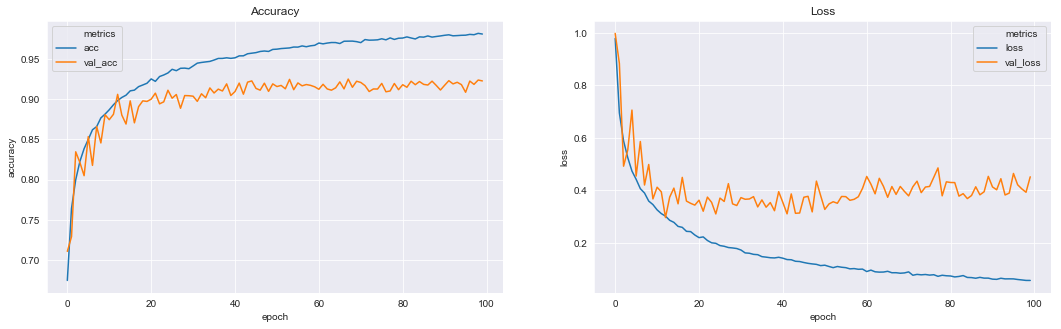

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
sns.set_style('darkgrid')
acc_train_val = acc_train_val.melt('epoch', var_name='metrics', value_name='accuracy')
ax_acc = sns.lineplot(x="epoch", y="accuracy", hue='metrics', data=acc_train_val, ax=ax[0])
ax_acc.set_title('Accuracy')
ax_acc.plot()
loss_train_val = loss_train_val.melt('epoch', var_name='metrics', value_name='loss')
ax_l = sns.lineplot(x="epoch", y="loss", hue='metrics', data=loss_train_val, ax=ax[1])
ax_l.set_title('Loss')
ax_l.plot()

Si bien overfitea, en la epoch 67 consigue mejor accuracy en validation que incluso otros modelos en los que se utiliza técnicas de regularización. 

## 9. Evaluate final model on the *testing* set

In [88]:
############
# [COMPLETE] 
# Evaluate your model on the testing set.
NET_IMG_ROWS = 128
NET_IMG_COLS = 128
BATCH_SIZE = 32
CHANNELS = 3
POOLING = 'avg'
TRAIN_BASE_LAYERS = True
L2 = 0
DROP_RATE = 0
NUM_CLASSES = 10
# Test data generator
datagen_test = ImageDataGenerator(
    rescale=1. / 255
)
generator_test = datagen_test.flow_from_directory('cifar10_images/test',
                                                  target_size=(NET_IMG_ROWS, NET_IMG_COLS),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')
base_model = MobileNet(
    input_shape=(NET_IMG_ROWS, NET_IMG_COLS, CHANNELS),   # Input image size
    weights='imagenet',                                   # Use imagenet pre-trained weights
    include_top=False,                                    # Drop classification layer
    pooling=POOLING
)
for layer in base_model.layers:
    layer.trainable = TRAIN_BASE_LAYERS

x = base_model.output
x = Dense(1024, activation='relu', kernel_regularizer=l2(L2))(x)
x = Dropout(DROP_RATE)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

best_model = Model(inputs=base_model.input, outputs=predictions)
############

Found 10000 images belonging to 10 classes.


In [89]:
# Loading best model snapshot weights
best_model.load_weights(thedir + best_model_exp_name + '/' + 'weights.67-0.41.hdf5')
best_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adadelta',
    metrics=['accuracy'])

In [90]:
results = best_model.evaluate_generator(generator_test)
print('test loss:', results[0], 'test acc:', results[1])

test loss: 0.4470298206795473 test acc: 0.9094
